# Model Predictive Control Demo

This is a demo for the Model Predictive Control (MPC) package $\texttt{mpc_tools}$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mpc_tools as mpc

## Linear Inverted Pendulum

Here we stibilize a linear inverted pendulum with mass $m$ and length $l$, subject to the gravity acceleration $g$.

In [2]:
m = 1.
l = 1.
g = 10.

The linearized continuous-time dynamics is 
\begin{equation}
\dot x = A x + B u =
\begin{bmatrix}
0 & 1 \\ g/l & 0
\end{bmatrix}
x +
\begin{bmatrix}
0 \\ 1/(ml^2)
\end{bmatrix}
u.
\end{equation}
The discrete-time linear system can be defined from its continuous-time representation setting a sampling time $t_s$ (the exact zero-order-hold discretization is used).

In [3]:
A = np.array([
    [0., 1.],
    [g/l, 0.]
])
B = np.array([
    [0.],
    [1/(m*l**2.)]
])
t_s = .1
sys = mpc.DTLinearSystem.from_continuous(t_s, A, B)

At each each step, the following optimal control is solved
\begin{align}
\min \quad &
\sum_{k=0}^{N-1} (x_k^T Q x_k + u_k^T R u_k) + x_N^T P x_N \\
\text{subject to} \quad & x_{k+1} = A x_k + B u_k, \quad k = 0,1,\ldots,N-1, \\
& x_0 \ \text{given}, \\
& u_k \in \mathcal U, \quad k = 0,1,\ldots,N-1, \\
& x_k \in \mathcal X, \quad k = 1,2,\ldots,N-1, \\
& x_N \in \mathcal X_N, \\
\end{align}
By default $P=Q$ but, for staibility reasons, sometimes it's preferable to use the solution of the Discrete Algebraic Ricccati Equation (DARE)
\begin{equation}
P = (A+BK)^T P (A+BK) + Q + K^T R K
\end{equation}
where $K = -(B^T P B + R)^{-1} B^T P A$ is the optimal feedback $u_k = K x_k$.
This can be done setting $\texttt{terminal_cost = 'dare'}$.

In [4]:
N = 5
Q = np.eye(A.shape[0])/100.
R = np.eye(B.shape[1])
terminal_cost = 'dare'
controller = mpc.MPCController(sys, N, Q, R, terminal_cost)

Input and state constraints have to be linear and they can be enforced as bounds (e.g., $u_{max} \geq u_k \geq u_{min}$) or as generic linear inqualities (e.g., $G u_k \leq g$).

In [5]:
x_max = np.array([[np.pi/6.],[np.pi/22./(N*t_s)]])
x_min = -x_max
controller.add_state_bound(x_max, x_min)
u_max = np.array([[m*g*l*np.pi/8.]])
u_min = -u_max
controller.add_input_bound(u_max, u_min)

To ensure stability of the closed loop system two terminal constraints are available:

1) $\texttt{terminal_constraint = 'origin'}$: this option imposes $x_N = 0$ which is sufficient to ensure stability (regardless the terminal cost) but in most cases it's excessive.

2) $\texttt{terminal_constraint = 'moas'}$: this option imposes $\mathcal{X}_N \in \mathcal{O}_{\infty}$ where $\mathcal{O}_{\infty}$ denotes the Maximum Output Admissible Set for the system closed loop system $x_{k+1} = (A + BK) x_k$, with $K$ derived from the DARE.
Mathematically speaking, we have that $x_N \in \mathcal{O}_{\infty} \Leftrightarrow \{ x_k \in \mathcal{X} \wedge u_k \in \mathcal{U} \} \ \forall k \geq N$.
This constraint, if coupoled with the DARE terminal cost, is sufficient condition for the stability of the closed loop system.

In [6]:
terminal_constraint = 'moas'
controller.set_terminal_constraint(terminal_constraint)

We now assemble the controller and simulate the closed loop system for $N_{sim}$ steps starting from the initial condition $x_0$.

In [7]:
controller.assemble()
N_sim = 50
x_0 = np.array([
    [np.pi/10.],
    [0.]
])
u = []
x = []
x.append(x_0)
for k in range(0, N_sim):
    u.append(controller.feedback(x[k]))
    x.append(sys.A.dot(x[k]) + sys.B.dot(u[k]))

We can plot the solution using the functions $\texttt{plot_input_sequence(.)}$ and $\texttt{plot_state_trajectory(.)}$

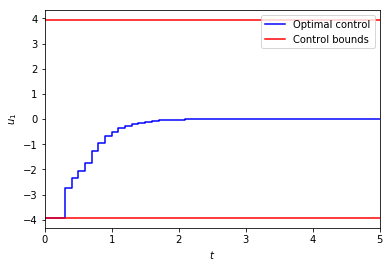

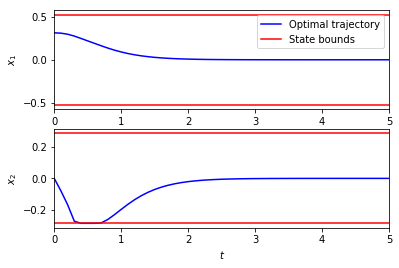

In [8]:
mpc.plot_input_sequence(u, t_s, N_sim, u_max, u_min)
plt.show()
mpc.plot_state_trajectory(x, t_s, N_sim, x_max, x_min)
plt.show()

We can get the explict solution of the optimal control problem and plot the consequent state partition.

In [9]:
controller.compute_explicit_solution()

Computing critical region for the active set []
Computing critical region for the active set [0]
Computing critical region for the active set [1]
Computing critical region for the active set [11]
Computing critical region for the active set [13]
Computing critical region for the active set [14]
Computing critical region for the active set [15]
Computing critical region for the active set [16]
Computing critical region for the active set [17]
Computing critical region for the active set [0, 2]
LICQ does not hold for the active set [0, 13]
    unfeasible critical region detected
Computing critical region for the active set [0, 16]
Computing critical region for the active set [0, 18]
Computing critical region for the active set [1, 3]
LICQ does not hold for the active set [1, 11]
    unfeasible critical region detected
Computing critical region for the active set [1, 17]
Computing critical region for the active set [1, 19]
Computing critical region for the active set [11, 14]
Computing cr

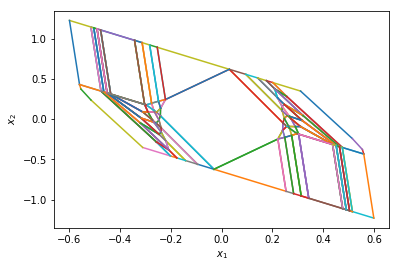

In [10]:
for cr in controller.critical_regions:
    cr.polyhedron.plot()
plt.show()

The result from the explicit solution and the optimal control problem is, of course, the same: let's take $x_0$ for example.

In [11]:
u_explicit = controller.evaluate_explicit_solution(x_0)[0]
u_implicit = controller.feedforward(x_0)
print('Optimal control from the explicit solution: ' + str(u_explicit.flatten()))
print('Optimal control from the implicit solution: ' + str(u_implicit.flatten()))

Optimal control from the explicit solution: [-3.92699082 -3.92699082 -3.92699082 -2.75365566 -2.34243615]
Optimal control from the implicit solution: [-3.92699082 -3.92699082 -3.92699048 -2.75365603 -2.34243618]


## Cart Pole

We now place the pendulum over a cart with mass $M$, the new input is the force applied to the cart.

In [12]:
M = 1.

The linearized dynamics becomes
\begin{equation}
\dot x =
\begin{bmatrix}
0 & 0 & 0 & 1
\\
0 & 0 & 0 & 1
\\
0 & -mg/M & 0 & 0
\\
0 & -(M+m)g/(Ml) & 0 & 0
\end{bmatrix}
x +
\begin{bmatrix}
0
\\
0
\\
1/M
\\
1/(Ml)
\end{bmatrix}
u.
\end{equation}

In [13]:
A = np.array([
    [0., 0., 1., 0.,],
    [0., 0., 0., 1.,],
    [0., -m*g/M, 0., 0.,],
    [0., (M+m)*g/(l*M), 0., 0.,]
])
B = np.array([
    [0.],
    [0.], 
    [1./M], 
    [1./(l*M)]
])
sys = mpc.DTLinearSystem.from_continuous(t_s, A, B)

In this case it's advisable to use a shorter horizon $N$ and to not impose any terminal constraint in order to have a compact optimization problem (note that doing this closed-loop stability is no longer guaranteed).

In [14]:
N = 2
terminal_constraint = None

The new parameters are the following.

In [15]:
x_max = np.array([
    [2.5],
    [np.pi/6.],
    [4.],
    [np.pi/18./(N*t_s)]
])
x_min = -x_max
u_max = np.array([[10.]])
u_min = -u_max
Q = np.eye(A.shape[0])
R = np.eye(B.shape[1])
x_0 = np.array([
    [0.],
    [np.pi/10.],
    [0.],
    [0.]
])

We can now assemble the controller for the new system.

In [16]:
controller = mpc.MPCController(sys, N, Q, R, terminal_cost)
controller.add_state_bound(x_max, x_min)
controller.add_input_bound(u_max, u_min)
controller.set_terminal_constraint(terminal_constraint)
controller.assemble()

We simulate the closed loop system.

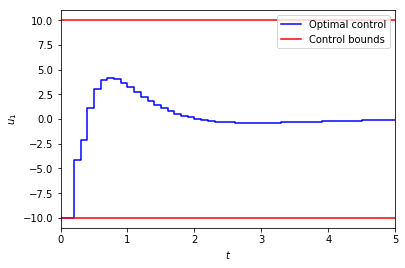

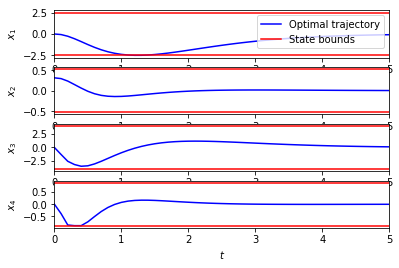

In [17]:
u = []
x = []
x.append(x_0)
for k in range(0, N_sim):
    u.append(controller.feedback(x[k]))
    x.append(sys.A.dot(x[k]) + sys.B.dot(u[k]))
mpc.plot_input_sequence(u, t_s, N_sim, u_max, u_min)
plt.show()
mpc.plot_state_trajectory(x, t_s, N_sim, x_max, x_min)
plt.show()

In this case the explicit solution might take much more time. The state space has now 4 dimensions, but we cann still plot the 2D projections of the critical regions.

In [ ]:
controller.compute_explicit_solution()

Computing critical region for the active set []
Computing critical region for the active set [0]
Computing critical region for the active set [1]
Computing critical region for the active set [4]
Computing critical region for the active set [6]
Computing critical region for the active set [7]
Computing critical region for the active set [8]
Computing critical region for the active set [10]
Computing critical region for the active set [11]
Computing critical region for the active set [12]
Computing critical region for the active set [14]
Computing critical region for the active set [15]
Computing critical region for the active set [16]
Computing critical region for the active set [18]
Computing critical region for the active set [19]
Computing critical region for the active set [0, 2]
LICQ does not hold for the active set [0, 4]
    corrected active set [4]
Computing critical region for the active set [4]
LICQ does not hold for the active set [0, 7]
    corrected active set [7]
Computing

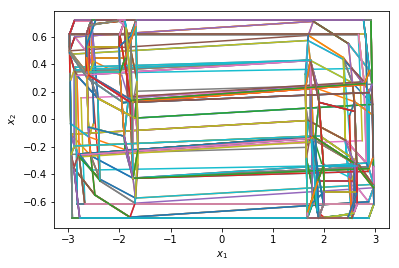

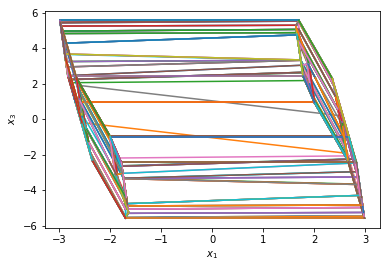

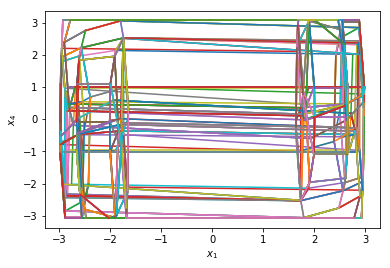

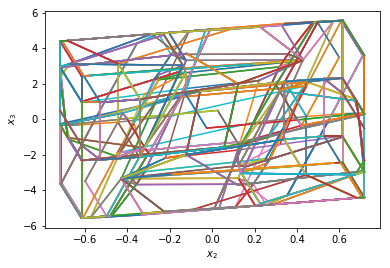

In [ ]:
projections = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]]
for prj in projections:
    for cr in controller.critical_regions:
        cr.polyhedron.plot(prj)
    plt.show()

We finally check that the explicit solution is correct.

In [ ]:
u_explicit = controller.evaluate_explicit_solution(x_0)[0]
u_implicit = controller.feedforward(x_0)
print('Optimal control from the explicit solution: ' + str(u_explicit.flatten()))
print('Optimal control from the implicit solution: ' + str(u_implicit.flatten()))